# Hyperparameter Optimization

In this tutorial we will use autoregressive approaches for virtual sensors to calculate the system response of an ESP System with external force from a shaker. This Tutorial introduces the concept of Hyperparameter optimization to find optimal parameters for our model. Please make sure to go through the basic tutorials `linear_models.ipynb`, '`ARNN.ipynb` and `RNN.ipynb`. We will start by loading the data in the same way as before.

The optimisation of hyperparameters defines a key point in the creation of deep learning models. The exact choice of hyperparameters is usually model and problem dependent, making hyperparameter optimisation necessary for most use cases.

Hyperparameters are all adjustable model and training variables that are not adjusted by a gradient-based method. In deep learning research, there is a great deal of work on optimisation. This tutorial focuses on grid search and model-based sequential optimisation.

## Loading Data
In a first step we load the already measured data and convert them into `pandas.DataFrames`. Our example Data consists of three individually Measured datasets. To load the data properly we need information about the specific sensors. In our case we define sensors: 
 * 12 input sensors
 * 3 output sensors
 
Furthermore, (if not given as `time` in the mat file) we need the corrosponsing sampling rate `fs` of the data.In our case:
 * fs=50000

Fixing the sampling rate will raise an Attention Message. We save the individual Measurments in a list of `pandas.DataFrames`

In [1]:
import os
import pandas as pd
import numpy as np
data_path = os.path.join(os.path.abspath(""), 'data')

input_sensors = [f'input_{i}' for i in range(1, 10)]
output_sensors = [f'output_{i}' for i in range(1, 4)]

file_names = [f for f in os.listdir(data_path) if
                    os.path.isfile(os.path.join(data_path, f))]
df_list = [pd.read_parquet(os.path.join(data_path, n)) for n in file_names]
fs = 1/np.mean(df_list[0].index.diff().dropna())

## Plot the Data
Before we start with the actual preprocessing we want to plot the given data to get a feeling for the properties. These are high-frequency acceleration data recorded on a shaker. For convinience we just plot the first entry of our list of DataFrames
<img src="./img/Mehrachspruefstand_hitl.jpg" alt="" width="600"/>.

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

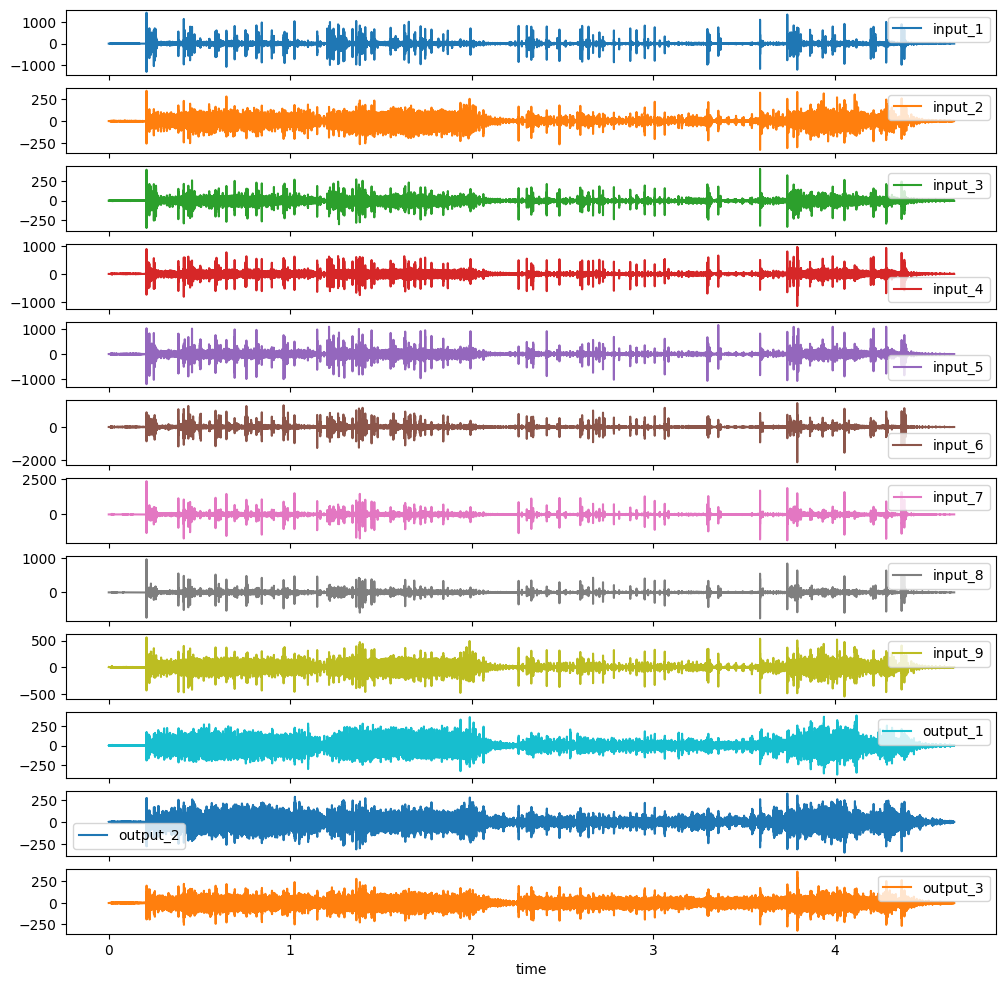

In [2]:
df_list[0].plot(subplots=True, sharex=True, figsize=(12,12))

## Data Preprocessing

When looking at the data, the high range in which the accelerations move is striking. For many machine learning models, preprocessing is therefore necessary. Our toolbox uses the class `Meas_handling` for the entire preprocessing. `Meas_handling` is used to transform the data into a normally distributed range. Furthermore, the entire frequency range is not relevant for our analysis.

Furtehrmore we split the data in training and evaluation data. We use the first two Measurments as training and the last one as evaluation

In [3]:
from softsensor.meas_handling import Meas_handling
from sklearn.preprocessing import StandardScaler

data_handle = Meas_handling(df_list[:2], file_names[:2], input_sensors, output_sensors, fs,
                            df_list[2:], file_names[2:])

data_handle.Resample(fs=10000)
freq_lim = (90, 4000)
data_handle.Filter(freq_lim)
data_handle.Scale(StandardScaler())

The optimisation of hyperparameters is a complex problem that requires a high computational capacity. It therefore makes sense to optimise on a GPU. Therefore, the first step is to check whether a GPU is available.

In [4]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Training on', device)

Training on cpu


## Grid Search

For an autoregressive neural network, the hyperparameters are composed of model parameters and training parameters.  We start our consideration with a grid search. This is an extensive procedure that considers each parameter combination in a grid individually. With an increasing number of parameters, the number of models to be trained increases exponentially. We therefore focus on the parameters `learning rate` and `stabilizer` as two training parameters. If possible, it makes sense to perform the optimisation either on a gpu or a remote computer.

To optimise the hyperparameters, the softsensor toolbox contains the `Hyperparameter_optimisation` tools which include the grid search. For execution, all static parameters and the parameter grid must be defined.


In [5]:
from softsensor.hyperparameter_optimization import grid_search
import torch.nn as nn

static_params = {'input_channels': 9,
                'pred_size': 3,
                'window_size': 50,
                'rnn_window': 50,
                'max_epochs': 2, # 30,
                'patience': 3,
                'hidden_size': [128, 64, 32, 16],
                'optimizer': 'Adam',
                'stab_method': 'const'
                }

grid = {'s1': [5e-4, 1e-3],#, 1.5e-3, 2e-3],
        'lr': [1e-3, 5e-3, 1e-2]#, 1.5e-2, 2e-2]
       }

criterion = nn.MSELoss()
model_type = 'ARNN'
result_df, best_model = grid_search(data_handle, criterion, model_type, static_params, grid, val_prediction=True, device=device, key='short', print_results=False)

Run 1/6 started with parameters {'lr': 0.001, 's1': 0.0005}...


Run 1/6 finished with loss 0.5666202731696239 and parameters {'lr': 0.001, 's1': 0.0005}, time=5s 



Run 2/6 started with parameters {'lr': 0.001, 's1': 0.001}...


Run 2/6 finished with loss 0.5631618715618555 and parameters {'lr': 0.001, 's1': 0.001}, time=4s 



Run 3/6 started with parameters {'lr': 0.005, 's1': 0.0005}...


Run 3/6 finished with loss 0.6313775003257616 and parameters {'lr': 0.005, 's1': 0.0005}, time=4s 



Run 4/6 started with parameters {'lr': 0.005, 's1': 0.001}...


Run 4/6 finished with loss 0.6108140711486694 and parameters {'lr': 0.005, 's1': 0.001}, time=4s 



Run 5/6 started with parameters {'lr': 0.01, 's1': 0.0005}...


Run 5/6 finished with loss 0.5789390390689501 and parameters {'lr': 0.01, 's1': 0.0005}, time=4s 



Run 6/6 started with parameters {'lr': 0.01, 's1': 0.001}...


Run 6/6 finished with loss 0.6723552185464667 and parameters {'lr': 0.01, 's1': 0.001}, time=4s 



## Visualization

We now visualise the loss over the individual hyperparameters. For 2 hyperparameters it makes sense to display them as even in the 3 dimensional space. For more parameters, other techniques such as scatter plots must be used.

Text(0.5, 0.5, 'stabelizer')

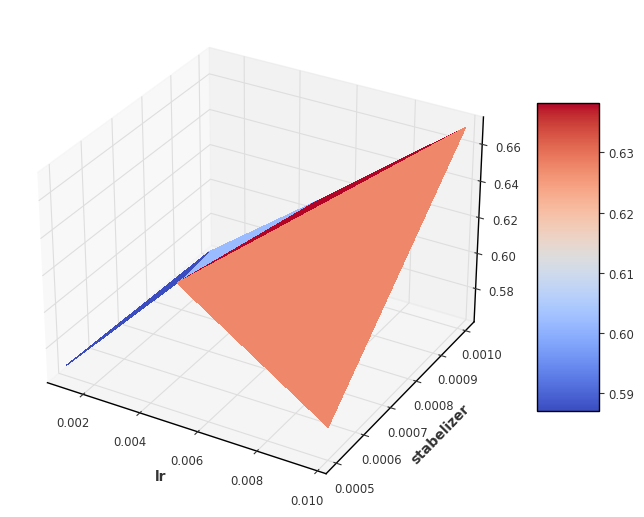

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))
X = result_df['lr']
stab_list = list(result_df['stabelizer'])
Y = [dic['eta'][0] for dic in stab_list]
Z = result_df['loss']
surf = ax.plot_trisurf(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('lr')
ax.set_ylabel('stabelizer')

## Sequential model-based optimization

In contrast to grid search, model-based optimisation does not specify a parameter grid in advance, but only limits. The optimisation works with the so-called Tree of Parzan Estimator which samples from a space of hyperparameters. The aim is to proceed sequentially towards the optimal hyperparameters. In each case, a combination of hyperparameters is selected and then a substitute model is used to determine which combination is likely to produce the best results. Mathematically, the optimisation works with the so-called Tree of Parzan Estimator.


In [7]:
from softsensor.hyperparameter_optimization import hyperopt_search
from hyperopt import hp

static_params = {'input_channels': 9,
                'pred_size': 3,
                'window_size': 50,
                'rnn_window': 50,
                'max_epochs': 2,# 30,
                'patience': 3,
                'hidden_size': [128, 64, 32, 16],
                'optimizer': 'Adam',
                'stab_method': 'const'
                }

grid_params = {'lr': hp.uniform('lr', 1e-4, 1e-2),
              's1': hp.uniform('s1', 1e-3, 1e-1)
               }

criterion = nn.MSELoss()
model_type = 'ARNN'
result_df, best_model = hyperopt_search(data_handle, criterion, model_type,
                                        static_params, grid_params, max_iterations=4,
                                        val_prediction=True, device=device, key='short', 
                                        print_results=False)

  0%|          | 0/4 [00:00<?, ?trial/s, best loss=?]

 25%|██▌       | 1/4 [00:04<00:14,  4.99s/trial, best loss: 0.5709947741654966]

 50%|█████     | 2/4 [00:09<00:09,  4.99s/trial, best loss: 0.5709947741654966]

 75%|███████▌  | 3/4 [00:15<00:05,  5.09s/trial, best loss: 0.5709947741654966]

100%|██████████| 4/4 [00:20<00:00,  5.03s/trial, best loss: 0.5709947741654966]

100%|██████████| 4/4 [00:20<00:00,  5.03s/trial, best loss: 0.5709947741654966]

## Visualization

We now visualise the loss over the individual hyperparameters. For 2 hyperparameters it makes sense to display them as even in the 3 dimensional space. For more parameters, other techniques such as scatter plots must be used.

Text(0.5, 0.5, 'stabelizer')

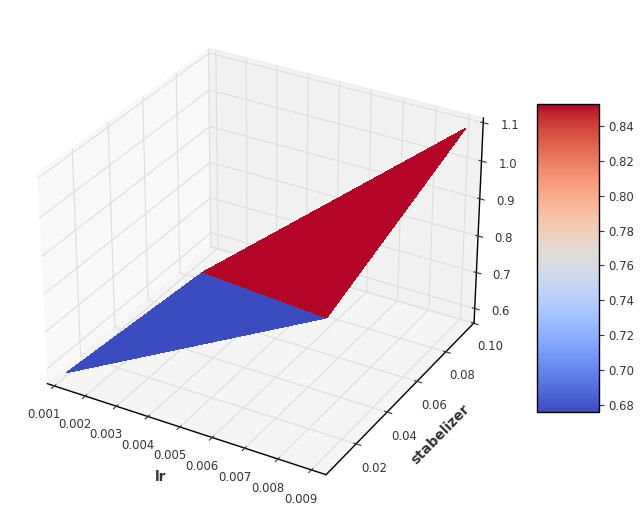

In [8]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))
X = result_df['lr']
stab_list = list(result_df['stabelizer'])
Y = [dic['eta'][0] for dic in stab_list]
Z = result_df['loss']
surf = ax.plot_trisurf(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('lr')
ax.set_ylabel('stabelizer')

## Model Evaluation
To Evaluate our model on testing data we use the predefined functions `comp_pred`, which computes the prediction for a defined track in the data_handle class. As track we choose our testing track, which can be accessed using the internal variable `test_names`. Furthermore we compute

In [9]:
from softsensor.eval_tools import comp_pred, comp_error
from softsensor.linear_methods import tf

tf_class = tf(window_size=1024,hop=512, fs=10000)
tf_class.fit(data_handle.train_df, input_sensors, output_sensors)

track = data_handle.test_names[0]
models = [best_model, tf_class]
pred_df = comp_pred(models, data_handle, track, names=['Neural Network', 'TF'])

In [10]:
pred_df.filter(regex='a_PCB_P10_A1S_Z').plot(figsize=(12,4))
pred_df.filter(regex='a_PCB_P10_A1S_Z')[1:1.02].plot(figsize=(12,4))

TypeError: no numeric data to plot

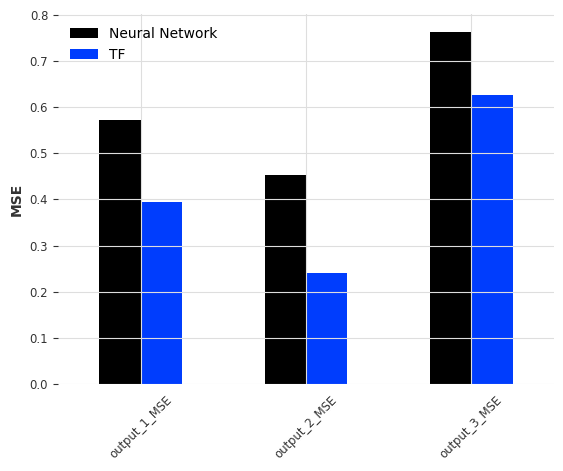

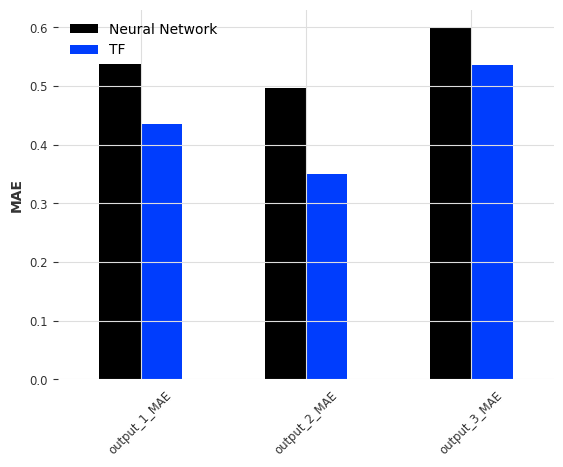

In [11]:
error = comp_error(pred_df, output_sensors, fs, names=['Neural Network', 'TF'], metrics=['MSE', 'MAE'], freq_range=freq_lim)
for n in ['MSE', 'MAE']:
    error.filter(regex=n, axis=0).plot.bar(ylabel=f'{n}', rot=45)